# Импорт библиотек

In [1]:
import numpy as np
from gzip import open # NB: overrides standard open()
import pickle as pkl
import pandas as pd
import warnings 
from glob import glob
import os
import math
import functools

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.metrics import mean_squared_error

In [5]:
from numpy import linalg as LA

In [6]:
from sklearn.metrics import r2_score

In [7]:
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

### Отключим предупреждения Anaconda

In [8]:
warnings.simplefilter('ignore')

# Загрузим данные

In [151]:
Xdata_numpy = pkl.load(open('C:/Users/admin/Desktop/PLS_continue_2020/X.pkl.gz', 'rb'))
Ydata = pkl.load(open('C:/Users/admin/Desktop/PLS_continue_2020/y.pkl.gz', 'rb'))

# N-PLS1

# Приближение к правильному алгоритму

 ### Опишу ка я центрирование в виде класса, для удобства.

In [152]:
class centrir(BaseEstimator):
    """"Этот класс производит центрирование, а потом из центрированных данных переходит обратно"""
    def  __init__(self, testSize=0.02857, column_y=0):
        self.testSize = testSize
        self.column_y=column_y
    
    def centering_and_cv(self,xx,yy):
        x=xx.copy()
        y=yy.copy()
        x_centrir=np.array(x)
        y_centrir=y.iloc[:,self.column_y].to_numpy()
        x_centrir -= x_centrir.mean(axis = 0)
        self.medium=y_centrir.mean() #Это сренее значение у. 
        y_centrir -= y_centrir.mean()
        
        X_train, X_test, y_train, y_test = train_test_split(
                x_centrir, y_centrir, test_size=self.testSize 
                )
        self.X_train=X_train
        self.X_test=X_test
        self.y_train=y_train
        self.y_test=y_test
        return self
    
    def recentering(self,yy):
            y=yy.copy()
            y+=self.medium
            return y
        
    

### Переделаю класс с учётом твоих замечаний и так, чтобы его можно было загнать в GridSearchCV

In [168]:
class Tri_PLS1_grid(RegressorMixin,BaseEstimator):
    def  __init__(self, n_components=2):
        self.n_components = n_components
        
            
    def fit(self, xx, yy):
        """Fits the model to the data (X, y)

        Parameters
        ----------
        X : ndarray
        y : 1D-array of shape (n_samples, )
            labels associated with each sample"""
        x=xx.copy()
        y=yy.copy()        
        Tt=np.zeros([x.shape[0],self.n_components])
        mass=np.zeros([y.shape[0]])
        y_copy=yy.copy()
        """"
        При различных способах разрезания исходных данных, массивы w_k и w_i имеют похожие значения и именно их я планирую 
        использовать для функции predict данного класса. """
        w_k_mass=np.zeros([self.n_components,x.shape[1],1])
        w_i_mass=np.zeros([self.n_components,x.shape[2],1])
        bf_array=[]
        for f in range(0,self.n_components):
            z=np.zeros([x.shape[1],x.shape[2]])
            x_product=np.zeros([x.shape[0],x.shape[1],x.shape[2]])
            for i in range(0,x.shape[0]):
                x_product[i,:,:]=x[i,:,:]*y[i]
            z=x_product.sum(axis=0)
            Wk, S, WI = np.linalg.svd(z)
            w_k=np.array(Wk[0,:]).reshape(x.shape[1],1)
            w_i=np.array(WI[0,:]).reshape(x.shape[2],1)
            w_k_mass[f,:,:]=w_k
            w_i_mass[f,:,:]=w_i
            
            for h in range(0,x.shape[0]):
                 Tt[h,f]=np.dot(np.dot(w_k.transpose(),x[h,:,:]),w_i)
            T=np.array(Tt[:,0:f+1]).reshape(x.shape[0],f+1)
            bf=np.dot(np.dot(np.linalg.inv(np.dot(T.transpose(),T)),T.transpose()),y)
            bf_array+=[bf]
            mmas=np.kron(Tt[:,f],np.kron(w_i,w_k).reshape(x.shape[1],x.shape[2])).reshape(x.shape[0],x.shape[1],x.shape[2])
            x=x-(mmas)             
            y=y-(np.dot(T,bf))
            mass+=np.dot(T,bf)   
        self.bf_array=bf_array
        self.train_error=mean_squared_error(mass,y_copy)
        self.w_k=w_k_mass
        self.w_i=w_i_mass
        
        return self
    
    
    def predict6666(self, xx):
        """" x is a test 3-D centering data."""
        x=xx.copy()
        Tt=np.zeros([x.shape[0],self.n_components])
        output=np.zeros([self.n_components])
        
        for f in range(0,self.n_components):
            w_k=np.array(self.w_k[f,:,:]).reshape(x.shape[1],1)
            w_i=np.array(self.w_i[f,:,:]).reshape(x.shape[2],1)
            for h in range(0,x.shape[0]):
                 Tt[h,f]=np.dot(np.dot(w_k.transpose(),x[h,:,:]),w_i)
            mmas=np.kron(Tt[:,f].reshape(x.shape[0]),np.kron(w_i,w_k).reshape(x.shape[1],x.shape[2])).reshape(x.shape[0],x.shape[1],x.shape[2])
            x=x-(mmas) 
            
        """" В функции fit мы двигались от исходных у к 0, а здесь нужно идти наоборот. И для этого нужен коэффициент bf"""
        y_find=np.zeros([x.shape[0],self.n_components])
        Tt=Tt.reshape(x.shape[0],self.n_components)
        
        y=np.random.normal(0,math.pow(10,-4),x.shape[0])
        
        for f in range(0,self.n_components):
            size_T=self.n_components-f
            T_part=Tt[:,0:size_T]
            bf=self.bf_array[size_T-1]
            y=y+(np.dot(T_part,bf))
        
        
        return y

    def predict(self, xx):
        x=xx.copy()
        xn=x.reshape(x.shape[0],x.shape[1]*x.shape[2])
        wk=np.array(self.w_k[0,:,:]).reshape(x.shape[1],1)
        wj=np.array(self.w_i[0,:,:]).reshape(x.shape[2],1)
        ww=np.kron(wk,wj).reshape(xn.shape[1])
        R=np.zeros([xn.shape[1],self.n_components])
        t=np.zeros([self.n_components,x.shape[0]])
        R[:,0]=ww.reshape(xn.shape[1])
        t[0,:]=np.dot(xn.copy(),ww).reshape(x.shape[0])
        I=np.eye(xn.shape[1])
        P=np.eye(xn.shape[1])
        p=np.ones([xn.shape[1]])
        B=np.zeros([self.n_components,self.n_components])
        for j in range(0,self.n_components):
            num=0
            for i in self.bf_array[j]:
                B[j,num]=i
                num+=1
        B=np.array([B]).reshape(self.n_components,self.n_components)
        b=B.sum(axis=0)
        kp=np.zeros([xn.shape[1]])
        for f in range(0,self.n_components-1):
            w=np.zeros([xn.shape[1]])
            w=np.kron(np.array(self.w_k[f,:,:]).reshape(x.shape[1],1),
                      np.array(self.w_i[f,:,:]).reshape(x.shape[2],1)
                     ).reshape(xn.shape[1])
            w_p=np.zeros([xn.shape[1]])
            w_p=np.kron(np.array(self.w_k[f+1,:,:]).reshape(x.shape[1],1),
                        np.array(self.w_i[f+1,:,:]).reshape(x.shape[2],1)
                       ).reshape(xn.shape[1])
            if (f<0.9):
                P=I-np.kron(w,w.transpose()).reshape(xn.shape[1],xn.shape[1])
                kp=np.dot(P,w_p).reshape(xn.shape[1])
            else:
                P=I-np.kron(kp,w.transpose()).reshape(xn.shape[1],xn.shape[1])
                kp=np.dot(P,w_p).reshape(xn.shape[1])
            
            
            
            t[f+1,:]=np.dot(xn.copy(),kp.copy()).reshape(x.shape[0])
            R[:,f+1]=kp.reshape(xn.shape[1])
        plt.imshow(R[0:4,:], aspect="auto")
        b_pls1=np.dot(R,b).reshape(xn.shape[1])
        y=np.dot(xn,b_pls1).reshape(x.shape[0])
        
        return y

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Tri_PLS1_grid(n_components=2), iid='warn', n_jobs=None,
             param_grid={'n_components': range(1, 10)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=True, scoring=None, verbose=0)

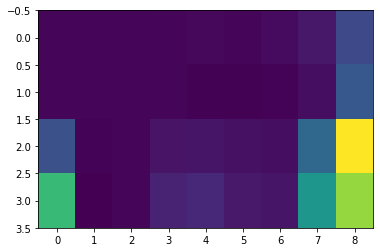

In [169]:
regressioModel=Tri_PLS1_grid()
parametrsNames={ 
                'n_components': range(1,10)
            }

gridCought=GridSearchCV(regressioModel, parametrsNames, cv=5, return_train_score=True)
gridCought.fit(da.X_train.copy(),da.y_train.copy())

In [97]:

            print("hggh")
            
            print(np.kron(w,w.transpose()).reshape(x.shape[1]*x.shape[2],x.shape[1]*x.shape[2]))
            
            for i in range(0,self.n_components-1):
                p=np.dot(P,w_p).reshape(xn.shape[1])
            p=np.dot(P,w_p).reshape(xn.shape[1])
            
            
            
            P=np.dot(P,I-np.kron(w,w.transpose()).reshape(xn.shape[1],xn.shape[1])).reshape(xn.shape[1],xn.shape[1])
            w_p=np.zeros([xn.shape[1]])
            w_p=np.kron(np.array(self.w_k[f+1,:,:]).reshape(x.shape[1],1),
                        np.array(self.w_i[f+1,:,:]).reshape(x.shape[2],1)
                       ).reshape(xn.shape[1])
           
            kp=np.dot(I-np.kron(w,w.transpose()).reshape(xn.shape[1],xn.shape[1]),w_p).reshape(xn.shape[1])
            
            p=np.multiply(p,kp)

hggh


NameError: name 'w' is not defined

In [154]:
dd=centrir()

In [155]:
da=dd.centering_and_cv(Xdata_numpy["X"][:,150:200,0:20],Ydata)

In [136]:
P=np.dot(P,I-np.kron(w,w.transpose()).reshape(xn.shape[1],xn.shape[1])).reshape(xn.shape[1],xn.shape[1])

NameError: name 'P' is not defined

In [ ]:
P*=I-np.kron(w,w.transpose()).reshape(xn.shape[1],xn.shape[1])
            P.reshape(xn.shape[1],xn.shape[1])

In [215]:
def predict(self, xx):
    x=xx.copy()
    w=np.zeros([self.n_components,x.shape[1]*x.shape[2]])
    x=x.reshape(x.shape[0],x.shape[1]*x.shape[2])
    wk=np.array(self.w_k[0,:,:]).reshape(x.shape[1],1)
    wj=np.array(self.w_i[0,:,:]).reshape(x.shape[2],1)
    ww=np.kron([wk,wi]).reshape(x.shape[1]*x.shape[2])
    R=np.zeros([x.shape[1]*x.shape[2],self.n_components])
    t=np.zeros([x.shape[1]*x.shape[2],x.shape[0]])
    R[:,0]=ww.reshape(x.shape[1]*x.shape[2],1)
    t[0,:]=np.dot([x.copy(),ww]).reshape(1,x.shape[0])
    I=np.eye([x.shape[1]*x.shape[2],x.shape[1]*x.shape[2]])
    P=np.eye([x.shape[1]*x.shape[2],x.shape[1]*x.shape[2]])
    p=np.zeros([x.shape[1]*x.shape[1]])
    B=np.zeros([self.n_components,self.n_components])
    for j in range(0,self.n_components):
        num=0
        for i in self.bf_array[j]:
            B[j,num]=i
            num+=1
    B=np.array([B]).reshape(self.n_components,self.n_components)
    print(B)
    print(B.sum(axis=0))
    for f in range(0,self.n_components-1):
        w_k=np.array(self.w_k[f,:,:]).reshape(x.shape[1],1)
        w_i=np.array(self.w_i[f,:,:]).reshape(x.shape[2],1)
        w=np.kron([w_k,w_i]).reshape(x.shape[1]*x.shape[2])
        P=np.dot([P,I-np.dot([w,w.transpose()]).reshape(x.shape[1]*x.shape[2],x.shape[1]*x.shape[2])])
            .reshape(x.shape[1]*x.shape[2],x.shape[1]*x.shape[2])
        w_k_p=np.array(self.w_k[f+1,:,:]).reshape(x.shape[1],1)
        w_i_p=np.array(self.w_i[f+1,:,:]).reshape(x.shape[2],1)
        w_p=np.kron([w_k_p,w_i_p]).reshape(x.shape[1]*x.shape[2])
        P=np.dot([P,w_p]).reshape(x.shape[1]*x.shape[1])
        t[f+1,:]=np.dot([x.copy(),P.copy()]).reshape(1,x.shape[0])
        R[:,f+1]=P.reshape(x.shape[1]*x.shape[2],1)
    
        
    

IndentationError: unexpected indent (<ipython-input-215-0b2a2e2c95ec>, line 29)

In [ ]:
def predict(self, xx):
        """" x is a test 3-D centering data."""
        x=xx.copy()
        Tt=np.zeros([x.shape[0],self.n_components])
        output=np.zeros([self.n_components])
        
        for f in range(0,self.n_components):
            w_k=np.array(self.w_k[f,:,:]).reshape(x.shape[1],1)
            w_i=np.array(self.w_i[f,:,:]).reshape(x.shape[2],1)
            for h in range(0,x.shape[0]):
                 Tt[h,f]=np.dot(np.dot(w_k.transpose(),x[h,:,:]),w_i)
            mmas=np.kron(Tt[:,f].reshape(x.shape[0]),np.kron(w_i,w_k).reshape(x.shape[1],x.shape[2])).reshape(x.shape[0],x.shape[1],x.shape[2])
            x=x-(mmas) 
            
        """" В функции fit мы двигались от исходных у к 0, а здесь нужно идти наоборот. И для этого нужен коэффициент bf"""
        y_find=np.zeros([x.shape[0],self.n_components])
        Tt=Tt.reshape(x.shape[0],self.n_components)
        
        y=np.random.normal(0,math.pow(10,-4),x.shape[0])
        
        for f in range(0,self.n_components):
            size_T=self.n_components-f
            T_part=Tt[:,0:size_T]
            bf=self.bf_array[size_T-1]
            y=y+(np.dot(T_part,bf))
        
        
        return y

### Зделаю ка я применение двух предыдущих классов тоже в виде класса

In [216]:
class run_class(RegressorMixin,BaseEstimator):
    def  __init__(self, testSize=0.1428, column_y=0, components_array=range(1,17), number_vallidations=5):
        self.testSize = testSize
        self.column_y=column_y
        self.components_array = components_array
        self.number_vallidations=number_vallidations
        
    def data_centerng(self,x,y):
        data=centrir(testSize=self.testSize, column_y=self.column_y)
        self.data_cv=data.centering_and_cv(x.copy(),y.copy())
        return self
    
    def cv(self):
        train_error=np.zeros([len(self.components_array)])
        test_error=np.zeros([len(self.components_array)])
        p_error=np.zeros([len(self.components_array)])
        n=0
        for i in self.components_array:
            regressioModel=Tri_PLS1_grid()
            parametrsNames={ 
                'n_components': [i]
            }

            gridCought=GridSearchCV(regressioModel, parametrsNames, cv=self.number_vallidations, return_train_score=True)
            gridCought.fit(self.data_cv.X_train.copy(),self.data_cv.y_train.copy())
            train_error[n]=gridCought.cv_results_[ "mean_train_score"]
            test_error[n]=gridCought.cv_results_[ "mean_test_score" ]
            
            p_error[n]=gridCought.score(self.data_cv.X_test.copy(),self.data_cv.y_test.copy())
            n+=1
        self.train_error=train_error
        self.test_error=test_error
        self.p_error=p_error
        plt.plot(train_error,".", color="red")
        plt.plot(test_error,".", color="blue")
        plt.plot(p_error,".", color="green")
        plt.show();
        return self

In [223]:
mod=run_class(testSize=0.2857,components_array=range(1,15),number_vallidations=5)

In [79]:
mod.data_centerng(Xdata_numpy["X"],Ydata)

run_class(column_y=0, components_array=range(1, 15), number_vallidations=5,
          testSize=0.2857)

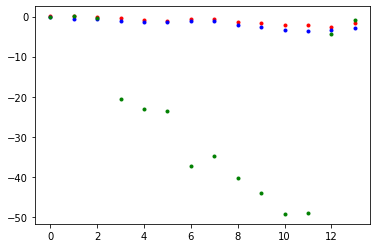

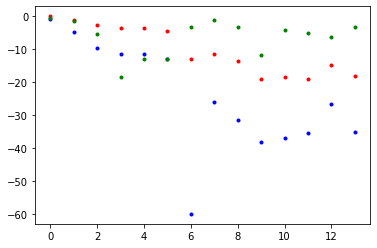

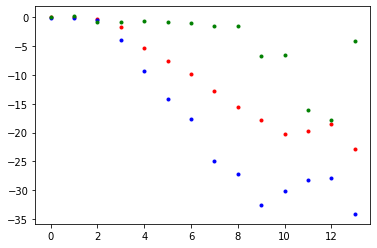

KeyboardInterrupt: 

In [224]:
for i in range(0,4):
    mod.data_centerng(Xdata_numpy["X"][:,35:70,1:25],Ydata)
    mod.cv()

# Дальше можно не проверять.

In [55]:
data=centrir()

In [56]:
data_2=data.centering_and_cv(Xdata_numpy["X"],Ydata)

In [57]:
%%time


#начинаем применять
regressioModel=Tri_PLS1_grid()
parametrsNames={ 
    'n_components': range(1,15)
}

gridCought=GridSearchCV(regressioModel, parametrsNames, cv=5,return_train_score=True)
gridCought.fit(data_2.X_train,data_2.y_train)


print(gridCought.best_params_)

{'n_components': 4}
Wall time: 25.7 s


In [20]:
import matplotlib as mpl

In [21]:
gridCought.best_estimator_

Tri_PLS1_grid(n_components=11)

In [227]:
W=gridCought.best_estimator_.w_k

W=W.reshape([4,206])
mpl.rc('font',family='Times New Roman')
plt.figure(figsize=(12,7))
plt.imshow(W,aspect="auto", origin='lower')

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)

plt.show();

ValueError: cannot reshape array of size 15 into shape (4,206)

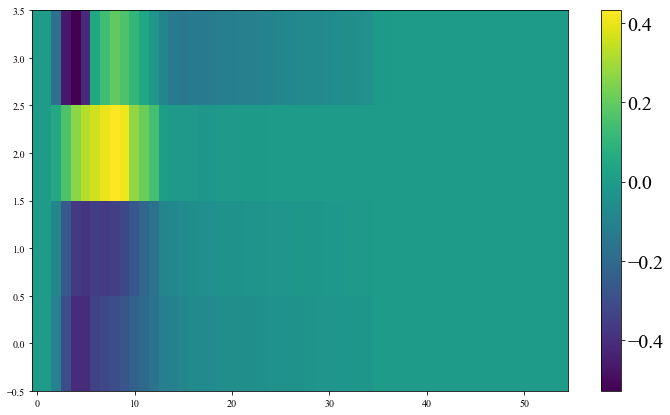

In [115]:
T=gridCought.best_estimator_.w_i
T=T.reshape([4,55])
mpl.rc('font',family='Times New Roman')
plt.figure(figsize=(12,7))
plt.imshow(T,aspect="auto", origin='lower')

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)

plt.show();

In [116]:
np.dot(T.transpose(),W)

array([[ 3.43310567e-07,  8.67223192e-07,  6.21866361e-06, ...,
         4.12987270e-05,  7.11619856e-06,  5.12894706e-05],
       [ 2.26745038e-06,  6.02219246e-06,  4.40682528e-05, ...,
         1.37398019e-04,  6.76523093e-05,  1.57177018e-04],
       [ 1.70882206e-04,  4.67035578e-04,  3.46300365e-03, ...,
         9.98245526e-04,  7.19329001e-03,  3.19972924e-03],
       ...,
       [-9.11345348e-07, -2.41190152e-06, -1.76203001e-05, ...,
        -6.11444517e-05, -2.58866495e-05, -6.87675149e-05],
       [-2.08303550e-06, -5.48180864e-06, -3.99694036e-05, ...,
        -1.49476840e-04, -5.86027834e-05, -1.75587186e-04],
       [-2.55659838e-07, -7.03129866e-07, -5.21414241e-06, ...,
        -4.40583155e-06, -9.31946709e-06, -2.85277463e-06]])

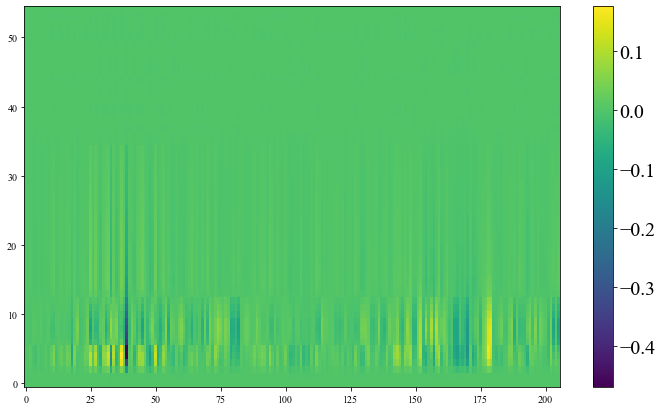

In [117]:
mpl.rc('font',family='Times New Roman')
plt.figure(figsize=(12,7))
plt.imshow(np.dot(T.transpose(),W),aspect="auto", origin='lower')

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)

plt.show();

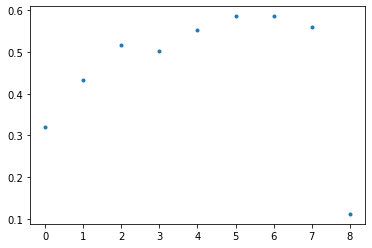

In [170]:
plt.plot(gridCought.cv_results_[ "mean_train_score" ],".")
plt.show();

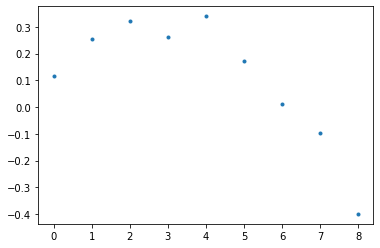

In [171]:
plt.plot(gridCought.cv_results_[ "mean_test_score" ],".")
plt.show();

In [172]:
max(gridCought.cv_results_[ "mean_test_score" ])

0.3392211522406808

In [231]:
data.recentering(gridCought.predict(data_2.X_test))

NameError: name 'data' is not defined

In [62]:
data.recentering(data_2.y_test)

array([43.27273755, 36.22622795])

In [141]:
gridCought.score(da.X_test,da.y_test)

-3.3932926501475134



-0.868573667894089

In [64]:
r2_score(data_2.y_test, gridCought.predict(data_2.X_test))

-3.0262722774322324

In [156]:
b=Tri_PLS1_grid(10)

In [157]:
for i in range(0,1):
    b.fit(X_train,y_train)

In [158]:
b.predict(X_test)

10


array([-3.60979414, -1.90610219,  3.88842363, -3.58264326, -3.30159225,
       12.05308735, -4.13845848, -6.75562827,  3.70127468, 10.81225349])

In [159]:
r2_score(y_test, b.predict(X_test))

10


0.26233076945872946

### Старый вариант класса. Ниже этой клетки можно в принципе и не проверять.

In [311]:
class Tri_PLS1_first(BaseEstimator, RegressorMixin):
    def  __init__(self, n_components=2, *, max_iter=500, tol=1e-06, copy=True):
        self.n_components = n_components
        self.max_iter = max_iter # Пока в ней нет необходимости. Прописал для общего фона.
        self.tol = tol
        self.copy = copy
        
    
    def fit(self, x, y):
        """Fits the model to the data (X, y)

        Parameters
        ----------
        X : ndarray, which was centering before running this code
            tensor data of shape (n_samples, N1, ..., NS)
        y : 1D-array of shape (n_samples, )
            labels associated with each sample"""
        Tt=np.zeros([x.shape[0],self.n_components])
        output=np.zeros([self.n_components])
        mass=np.zeros([y.shape[0]])
        y_copy=y
        """"
        При различных способах разрезания исходных данных, массивы w_k и w_i имеют похожие значения, и именно их я планирую 
        использовать для функции predict данного класса. """
        w_k_mass=np.zeros([self.n_components,x.shape[1],1])
        w_i_mass=np.zeros([self.n_components,x.shape[2],1])
        bf_array=[]
        for f in range(0,self.n_components):
            z=np.zeros([x.shape[1],x.shape[2]])
            x_product=np.zeros([x.shape[0],x.shape[1],x.shape[2]])
            for i in range(0,x.shape[0]):
                x_product[i,:,:]=x[i,:,:]*y[i]
            z=x_product.sum(axis=0)
            Wk, S, WI = np.linalg.svd(z)
            w_k=np.array(Wk[0,:]).reshape(x.shape[1],1)
            w_i=np.array(WI[0,:]).reshape(x.shape[2],1)
            w_k_mass[f,:,:]=w_k
            w_i_mass[f,:,:]=w_i
            t=np.zeros([x.shape[0]])
            for h in range(0,x.shape[0]):
                t[h]=np.dot(np.dot(w_k.transpose(),x[h,:,:]),w_i)
            t=np.array(t).reshape(x.shape[0])
            Tt[:,f]=t
            T=np.array(Tt[:,0:f+1]).reshape(x.shape[0],f+1)
            bf=np.dot(np.dot(np.linalg.inv(np.dot(T.transpose(),T)),T.transpose()),y)
            bf_array+=[bf]
            mmas=np.kron(t,np.kron(w_i,w_k).reshape(x.shape[1],x.shape[2])).reshape(x.shape[0],x.shape[1],x.shape[2])
            x=x-(mmas)             
            y=y-(np.dot(T,bf))
            mass+=np.dot(T,bf)   
            output[f]=mean_squared_error(mass,y_copy)
        # Оставил только чтобы контролировать воспроизводимость и адекватность. 
        plt.plot(output)
        plt.show();
        self.bf_array=bf_array
        self.train_error=output
        self.w_k=w_k_mass
        self.w_i=w_i_mass
        return self
    
    def predict(self, x, y_test):
        """" x is a test 3-D centering data."""
        Tt=np.zeros([x.shape[0],self.n_components])
        output=np.zeros([self.n_components])
        for f in range(0,self.n_components):
            w_k=np.array(self.w_k[f,:,:]).reshape(x.shape[1],1)
            w_i=np.array(self.w_i[f,:,:]).reshape(x.shape[2],1)
            t=np.zeros([x.shape[0]])
            for h in range(0,x.shape[0]):
                t[h]=np.dot(np.dot(w_k.transpose(),x[h,:,:]),w_i)
            t=np.array(t).reshape(x.shape[0])
            Tt[:,f]=t
            T=np.array(Tt[:,0:f+1]).reshape(x.shape[0],f+1)
            mmas=np.kron(t,np.kron(w_i,w_k).reshape(x.shape[1],x.shape[2])).reshape(x.shape[0],x.shape[1],x.shape[2])
            x=x-(mmas) 
            
        """" В функции fit мы двигались от исходных у к 0, а здесь нужно идти наоборот. И для этого нужен коэффициент bf"""
        y_find=np.zeros([x.shape[0],self.n_components])
        for d in range(0,self.n_components):
            y=np.random.normal(0, math.sqrt(self.train_error[d]), x.shape[0])
            for f in range(0,d+1):
                size_T=d+1-f
                T_part=T[:,0:size_T]
                bf=self.bf_array[size_T-1]
                y=y+(np.dot(T_part,bf))
            y_find[:,d]=y
            if (((d-6)<0.9) and ((d-6)>(-0.9))):
                print(y)
                print(y_test)
            output[d]=mean_squared_error(y,y_test)
        plt.plot(output)
        plt.show();
        self.test_error=output
        self.y_find=y_find
        return self

In [312]:
a=Tri_PLS1_first(17)

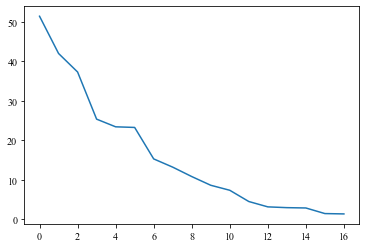

In [313]:
for i in range(0,1):
    a.fit(data_2.X_train,data_2.y_train)

[16.3690397   8.35658588  4.8764599   4.08315744 -1.10566639 -0.21604375
  3.52041394 -4.68734611  1.21353032 -3.09259296]
[ 14.64600637  -6.65260834   3.27807984  -4.64005226   4.40507881
   1.0451428   16.05197918 -13.79718301  -0.15706949   7.44718265]


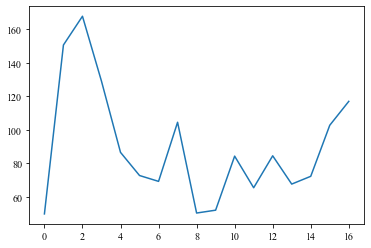

In [314]:
for i in range(0,1):
    a.predict(data_2.X_test,data_2.y_test)

In [80]:
a.y_find.shape

(10, 17)

In [317]:
r2_score(data_2.y_test, a.y_find[:,8])

0.34573519134502084

In [23]:
y_test9=y_test+asas
y_test99=a.y_find[:,6]+asas

In [24]:
mean_squared_error(y_test9,y_test99)

46.35540667228468

In [25]:
y_test

array([  4.55217322,   3.27807984,  -6.65260834,  -4.64005226,
        -0.15706949, -11.81077856,  -5.7521935 ,  -8.58399134,
        -1.37197484,   9.41508832])

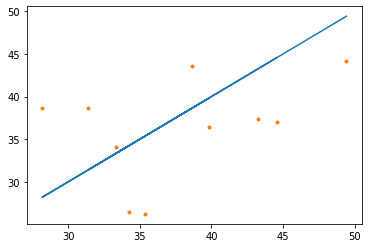

In [26]:
plt.plot(y_test9,y_test9)
plt.plot(y_test9,y_test99,".")
plt.show()

### Дальше идут черновики, и прочие нефункциональные или тренировочные элементы.

In [84]:
a

N_PLS1_first(copy=True, max_iter=500, n_components=27, norm_y_weights=False,
             scale=True, tol=1e-06)

In [ ]:
.reshape(x.shape[0],1)
-np.array(mass).reshape(1,x.shape[0]).mean()

In [179]:
y

array([34.19308759, 35.72443085, 46.32211944, 35.69579348, 47.44184036,
       33.34204937, 42.44462856, 39.9018207 , 44.39973652, 54.64066407,
       53.71596802, 44.04933373, 36.11255278, 34.24246421, 36.22622795,
       26.1974747 , 41.0398005 , 31.41066637, 34.07047331, 42.14770231,
       45.44679116, 21.41118209, 44.54683093, 35.35460545, 36.47993911])

In [395]:
output=np.zeros([parameters['numbers_of_components']])
for v in range(0,parameters['numbers_of_learning']):
    X_train, X_test, y_train, y_test = train_test_split(
        Xdata_numpy["X"], Ydata.iloc[:,parameters['column_y']], test_size=parameters['testSize'] 
        )
    x=X_train
    y=y_train
    y=np.array(y)
    x=np.array(x)
    Tt=[]
    mass=np.zeros([y.shape[0]])
    for f in range(0,parameters['numbers_of_components']):
        z=np.zeros([x.shape[1],x.shape[2]])
        for i in range(0,x.shape[2]):
            for j in range(0,x.shape[1]):
                zsum=0
                for k in range(0,x.shape[0]):
                    zsum= zsum+ x[k,j,i]*y[k]
                z[j,i]=zsum
        Wk, S, WI = np.linalg.svd(z)
        w_k=np.array(Wk[0,:]).reshape(x.shape[1],1)
        w_i=np.array(WI[0,:]).reshape(x.shape[2],1)
        t=[]
        for h in range(0,x.shape[0]):
            t+=[np.dot(np.dot(w_k.transpose(),x[h,:,:]),w_i)]
        t=np.array(t).reshape(x.shape[0],1)
        Tt+=[t]
        T=np.array(Tt).reshape(x.shape[0],f+1)
        bf=np.dot(np.dot(np.linalg.inv(np.dot(T.transpose(),T)),T.transpose()),y)
        mmas=np.kron(np.kron(w_i,w_k).reshape(x.shape[1],x.shape[2])
        
        for g in range(0,x.shape[0]):
            x[g,:,:]=x[g,:,:]-(t[g]*w_i.transpose()*w_k)
        y=y-(np.dot(T,bf))
        mass+=np.dot(T,bf)   
        output[f]+=error(mass,y_train)
np.array(output).reshape(1,parameters['numbers_of_components'])

array([[5.20396143e+04, 4.91918971e+04, 4.38839916e+04, 3.88590076e+04,
        3.28461510e+04, 2.71640444e+04, 2.06742360e+04, 1.51864921e+04,
        1.08940127e+04, 7.45914196e+03, 5.10460116e+03, 3.13773457e+03,
        1.85325287e+03, 8.68438137e+02, 4.09180232e+02, 2.46334649e+02,
        1.76439608e+02, 1.32129844e+02, 1.09666897e+02, 8.20938712e+01,
        4.59856659e+01, 2.60763430e+01, 1.10681096e+01, 4.58247849e+00,
        9.94812128e-01, 1.09443246e-07, 1.55442375e-08, 1.07111515e-08,
        4.36357780e-09, 8.25991184e-09, 8.28521838e-09, 3.91514087e-08,
        4.05800265e-07, 9.57270667e-08, 3.17840084e-06, 2.82484373e-06,
        6.49010797e-07, 2.30233617e-04, 7.71299123e-03, 1.62744298e-01,
        6.11296107e+01, 1.03835530e+03, 1.01042473e+03, 4.74122861e+03,
        6.23619775e+04, 9.49571644e+04, 1.22425553e+06, 5.50510253e+06,
        5.15620269e+06, 4.28673709e+06, 1.03028491e+09, 1.22720823e+12,
        9.71049882e+14, 6.76286674e+15, 4.44894505e+18]])

In [75]:
pp=np.array([[[1,2],[3,4]],[[5,6],[7,8]]])

In [76]:
pp

array([[[1, 2],
        [3, 4]],

       [[5, 6],
        [7, 8]]])

In [77]:
yu=np.array([1,2])

In [100]:
print(type(pp))

<class 'numpy.ndarray'>


In [78]:
np.dot(pp[1,:,:],yu[1])

array([[10, 12],
       [14, 16]])

In [286]:
x=X_train
y=y_train
y=np.array(y)
x=np.array(x)
Tt=[]
output=np.zeros([parameters['numbers_of_components']])
mass=np.zeros([y.shape[0]])
kk=[]
for f in range(0,parameters['numbers_of_components']):
    z=np.zeros([x.shape[1],x.shape[2]])
    x_product=np.zeros([y.shape[0],x.shape[1],x.shape[2]])
    for i in range(0,y.shape[0]):
        x_product[i,:,:]=np.dot(x[i,:,:],y[i])
    z=x_product.sum(axis=0)
    Wk, S, WI = np.linalg.svd(z)
    w_k=np.array(Wk[0,:]).reshape(x.shape[1],1)
    w_i=np.array(WI[0,:]).reshape(x.shape[2],1)
    
    t=[]
    for h in range(0,x.shape[0]):
        t+=[np.dot(np.dot(w_k.transpose(),x[h,:,:]),w_i)]
    t=np.array(t).reshape(x.shape[0],1)
    Tt+=[t]
    T=np.array(Tt).reshape(x.shape[0],f+1)
    bf=np.dot(np.dot(np.linalg.inv(np.dot(T.transpose(),T)),T.transpose()),y)
    kk+=[bf]
    for g in range(0,x.shape[0]):
        x[g,:,:]=x[g,:,:]-(t[g]*w_i.transpose()*w_k)
    y=y-(np.dot(T,bf))
    mass+=np.dot(T,bf)   
    output[f]+=mean_squared_error(mass,y_train)
print(kk)
fgffgffgfgf=np.array(output).reshape(1,parameters['numbers_of_components'])

[array([-1.66118692]), array([-6.29079172,  6.73688692]), array([-4.12522941,  1.04501877, -5.43633477]), array([-2.47312785, -0.77091171, -3.58375233,  0.30593637]), array([16.50410601, -5.00622902, -8.22588722,  1.24655259,  3.29071373]), array([-4.19790957, -2.35053163,  0.98214464,  0.34894549, -0.05205299,
        0.86235296]), array([-1.87063411,  0.91027459, -0.09391723,  0.92112484, -2.92076064,
        0.98227647, -0.96633831]), array([-3.40181009,  0.31731486,  0.53363854,  1.63610577,  0.3901178 ,
        2.24601301, -1.17585434, -0.2064675 ]), array([-0.44467154,  0.55624498, -0.64257114, -0.23228063,  0.52400954,
       -0.46183266, -0.72497265,  0.01414457,  0.54696848]), array([-9.11867149,  5.3415317 , 11.71030015, -3.67531275, -0.65128271,
        8.63820213, -5.58461098, -5.64958101,  0.19695864,  3.50070102]), array([-0.5694123 , -0.15692167,  0.21129866, -0.18233175,  0.30182872,
       -0.26179883,  0.48778146, -0.24362274,  0.02664971, -0.19194008,
        0.84289

In [79]:
pp.sum(axis=0)

array([[ 6,  8],
       [10, 12]])

In [125]:
vv=np.kron(np.array([7,6]),pp)

In [126]:
vv

array([[[ 7, 14,  6, 12],
        [21, 28, 18, 24]],

       [[35, 42, 30, 36],
        [49, 56, 42, 48]]])

In [130]:
vv[0,0,0:1]

array([7])

In [219]:
j=np.array([1,2,3])
jj=np.array([4,5,6])
jjj=np.array([7,8,9])

In [195]:
np.dot(ggg,j)

array([[32],
       [64],
       [96]])

In [191]:
j*jj

array([ 4, 10, 18])

In [192]:
j*ggg

array([[ 4, 10, 18],
       [ 8, 20, 36],
       [12, 30, 54]])

In [172]:
gg=j*jj.transpose()

In [178]:
gg

array([ 4, 10, 18])

In [181]:
ggg=np.kron(j,jj.transpose()).reshape(3,3)

In [184]:
ggg

array([[ 4,  5,  6],
       [ 8, 10, 12],
       [12, 15, 18]])

In [252]:
ggg*2

array([[ 8, 10, 12],
       [16, 20, 24],
       [24, 30, 36]])

In [183]:
np.kron(jjj,ggg).reshape(3,3,3)

array([[[ 28,  35,  42],
        [ 32,  40,  48],
        [ 36,  45,  54]],

       [[ 56,  70,  84],
        [ 64,  80,  96],
        [ 72,  90, 108]],

       [[ 84, 105, 126],
        [ 96, 120, 144],
        [108, 135, 162]]])

In [218]:
fff=np.kron(jjj,ggg).reshape(3,3,3)

In [225]:
np.dot(fff[0,:,:],j[1])

array([[ 56,  70,  84],
       [ 64,  80,  96],
       [ 72,  90, 108]])

In [ ]:
# пока в планах
class N_PLS1():
    def error(a,b):
        s=0
        for i in range(0,len(a)):
            s+=((a[i]-b.iloc[i]))**2
        return s
    def function_1(x,y,fn):
        Tt=[]
        mass=np.zeros([y.shape[0]])
        output=[]
        for f in range(0,fn):
            z=np.zeros([x.shape[1],x.shape[2]])
            for i in range(0,x.shape[2]):
                for j in range(0,x.shape[1]):
                    zsum=0
                    for k in range(0,x.shape[0]):
                        zsum= zsum+ x[k,j,i]*y[k]
                    z[j,i]=zsum
            Wk, S, WI = np.linalg.svd(z)
            w_k=np.array(Wk[0,:]).reshape(x.shape[1],1)
            w_i=np.array(WI[0,:]).reshape(x.shape[2],1)
            t=[]
            for h in range(0,x.shape[0]):
                t+=[np.dot(np.dot(w_k.transpose(),x[h,:,:]),w_i)]
            t=np.array(t).reshape(x.shape[0],1)
            Tt+=[t]
            T=np.array(Tt).reshape(x.shape[0],f+1)
            bf=np.dot(np.dot(np.linalg.inv(np.dot(T.transpose(),T)),T.transpose()),y)
            for g in range(0,x.shape[0]):
                x[g,:,:]=x[g,:,:]-(t[g]*w_i.transpose()*w_k)
            y=y-(np.dot(T,bf))
            mass+=np.dot(T,bf)
            output+=[error(mass,y_train)]
        return output
    def fit(x,y,fn):
        
            
        return y